In [1]:
import os
from dotenv import load_dotenv
load_dotenv(os.path.join("..", ".env"), override=True)

True

In [18]:
import json

from rich.console import Console
from rich.panel import Panel
from rich.text import Text

console = Console()


def format_message_content(message):
    """Convert message content to displayable string."""
    parts = []
    tool_calls_processed = False

    # Handle main content
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        # Handle complex content like tool calls (Anthropic format)
        for item in message.content:
            if item.get("type") == "text":
                parts.append(item["text"])
            elif item.get("type") == "tool_use":
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2, ensure_ascii=False)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))

    # Handle tool calls attached to the message (OpenAI format) - only if not already processed
    if (
        not tool_calls_processed
        and hasattr(message, "tool_calls")
        and message.tool_calls
    ):
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2, ensure_ascii=False)}")
            parts.append(f"   ID: {tool_call['id']}")

    return "\n".join(parts)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting."""
    for m in messages:
        msg_type = m.__class__.__name__.replace("Message", "")
        content = format_message_content(m)

        if msg_type == "Human":
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == "Ai":
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == "Tool":
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))


def format_message(messages):
    """Alias for format_messages for backward compatibility."""
    return format_messages(messages)


def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """Display a prompt with rich formatting and XML tag highlighting.

    Args:
        prompt_text: The prompt string to display
        title: Title for the panel (default: "Prompt")
        border_style: Border color style (default: "blue")
    """
    # Create a formatted display of the prompt
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r"<[^>]+>", style="bold blue")  # Highlight XML tags
    formatted_text.highlight_regex(
        r"##[^#\n]+", style="bold magenta"
    )  # Highlight headers
    formatted_text.highlight_regex(
        r"###[^#\n]+", style="bold cyan"
    )  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(
        Panel(
            formatted_text,
            title=f"[bold green]{title}[/bold green]",
            border_style=border_style,
            padding=(1, 2),
        )
    )

# more expressive runner
async def stream_agent(agent, query, config=None):
    async for graph_name, stream_mode, event in agent.astream(
        query,
        stream_mode=["updates", "values"], 
        subgraphs=True,
        config=config
    ):
        if stream_mode == "updates":
            print(f'Graph: {graph_name if len(graph_name) > 0 else "root"}')
            
            node, result = list(event.items())[0]
            print(f'Node: {node}')
            
            for key in result.keys():
                if "messages" in key:
                    # print(f"Messages key: {key}")
                    format_messages(result[key])
                    break
        elif stream_mode == "values":
            current_state = event

    return current_state

In [2]:
LS_DESCRIPTION = """List all files in the virtual filesystem stored in agent state.

Shows what files currently exist in agent memory. Use this to orient yourself before other file operations and maintain awareness of your file organization.

No parameters required - simply call ls() to see all available files."""

READ_FILE_DESCRIPTION = """Read content from a file in the virtual filesystem with optional pagination.

This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks to avoid context overflow.

Parameters:
- file_path (required): Path to the file you want to read
- offset (optional, default=0): Line number to start reading from  
- limit (optional, default=2000): Maximum number of lines to read

Essential before making any edits to understand existing content. Always read a file before editing it."""

WRITE_FILE_DESCRIPTION = """Create a new file or completely overwrite an existing file in the virtual filesystem.

This tool creates new files or replaces entire file contents. Use for initial file creation or complete rewrites. Files are stored persistently in agent state.

Parameters:
- file_path (required): Path where the file should be created/overwritten
- content (required): The complete content to write to the file

Important: This replaces the entire file content."""

FILE_USAGE_INSTRUCTIONS = """You have access to a virtual file system to help you retain and save context.

## Workflow Process
1. **Orient**: Use ls() to see existing files before starting work
2. **Save**: Use write_file() to store the user's request so that we can keep it for later 
3. **Research**: Proceed with research. The search tool will write files.  
4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the user's question directly.
"""

In [3]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict

from langgraph.prebuilt.chat_agent_executor import AgentState


class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]


def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}  # “두 딕셔너리를 합치되, 같은 키는 right 값을 사용” 이라는 뜻입니다.


class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

d:\AI_Labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
"""Virtual file system tools for agent state management.

This module provides tools for managing a virtual filesystem stored in agent state,
enabling context offloading and information persistence across agent interactions.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    return list(state.get("files", {}).keys())


@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem (injected in tool node)
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:1000]  # Truncate long lines
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    return "\n".join(result_lines)


@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem (injected in tool node)
        tool_call_id: Tool call identifier for message response (injected in tool node)

    Returns:
        Command to update agent state with new file content
    """
    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

In [12]:
# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question."""

# Full prompt
INSTRUCTIONS = (
    FILE_USAGE_INSTRUCTIONS + "\n\n" + "=" * 80 + "\n\n" + SIMPLE_RESEARCH_INSTRUCTIONS
)
print(INSTRUCTIONS)

You have access to a virtual file system to help you retain and save context.

## Workflow Process
1. **Orient**: Use ls() to see existing files before starting work
2. **Save**: Use write_file() to store the user's request so that we can keep it for later 
3. **Research**: Proceed with research. The search tool will write files.  
4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the user's question directly.



IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question.


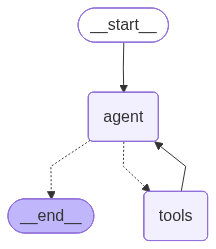

In [22]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Create agent using create_react_agent directly
from langchain_groq import ChatGroq
# model = ChatGroq(temperature=0, model_name= "qwen/qwen3-32b")  # qwen/qwen3-32b, openai/gpt-oss-120b
# model = ChatGroq(temperature=0, model_name= "openai/gpt-oss-120b")  # qwen/qwen3-32b, openai/gpt-oss-120b, gemma2-9b-it
model = ChatGroq(temperature=0, model_name= "gemma2-9b-it")  # qwen/qwen3-32b, openai/gpt-oss-120b, gemma2-9b-it

tools = [ls, read_file, write_file, web_search]

# Create agent with system prompt
agent = create_react_agent(
    model, tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [23]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
        "files": {},
    }
)
result

{'messages': [HumanMessage(content='Give me an overview of Model Context Protocol (MCP).', additional_kwargs={}, response_metadata={}, id='b6af16d9-f4ef-45c6-adba-625e2528fb35'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gtxag2289', 'function': {'arguments': '{"query":"Model Context Protocol (MCP)"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 1852, 'total_tokens': 1936, 'completion_time': 0.152727273, 'prompt_time': 0.034701015, 'queue_time': 0.025456301, 'total_time': 0.187428288}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--badd8608-eec3-4fcc-be18-93a005d63cf3-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'Model Context Protocol (MCP)'}, 'id': 'gtxag2289', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1852, 'output_tokens': 84, 'total_tokens': 1936}),
  ToolMessage(content='The 

In [24]:
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol (MCP)"                                                                       │
│ }                                                                                                               │
│    ID: gtxag2289                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed                                         │
│ by Anthropic to enable seamless integration between AI models and external systems like                         │
│ tools, databases, and other services. It acts as a standardized communication layer,                            │
│ allowing AI models to access and utilize data from various sources in a consistent and                          │
│ efficient manner. Essentially, MCP simplifies the process of connecting AI assistants                           │
│ to external services by providing a unified language for data exchange.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed by Anthropic to enable seamless         │
│ integration between AI models and external systems like tools, databases, and other services. It acts as a      │
│ standardized communication layer, allowing AI models to access and utilize data from various sources in a       │
│ consistent and efficient manner. Essentially, MCP simplifies the process of connecting AI assistants to         │
│ external services by providing a unified language for data exchange.                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯